# Time series forecasting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from datetime import datetime

In [3]:
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3h, Name: one, dtype: int64

* The only feature we have is the date time feature
    * Example: 2015-08-01 00:00:00
* The target is the number of rentals in the next 3 hours

In [4]:
citibike.index.min(), citibike.index.max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-08-31 21:00:00'))

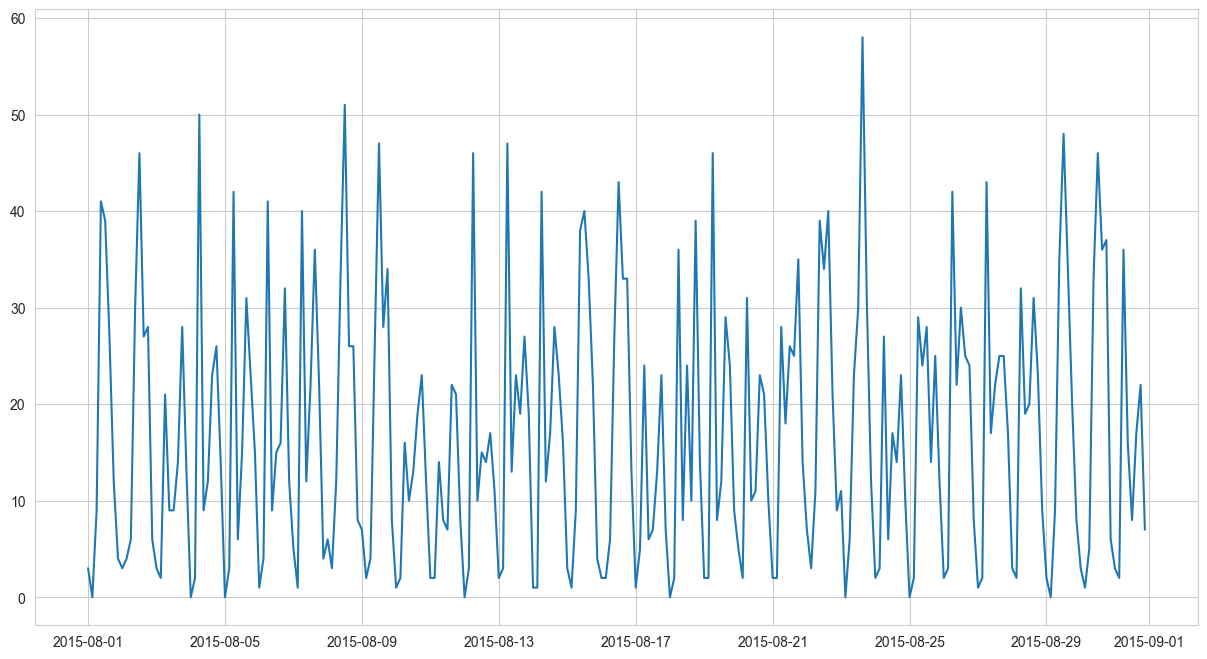

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(citibike)

* we see the day and night pattern
* we see the weekend and weekday pattern

## Train/test split

In [7]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [9]:
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

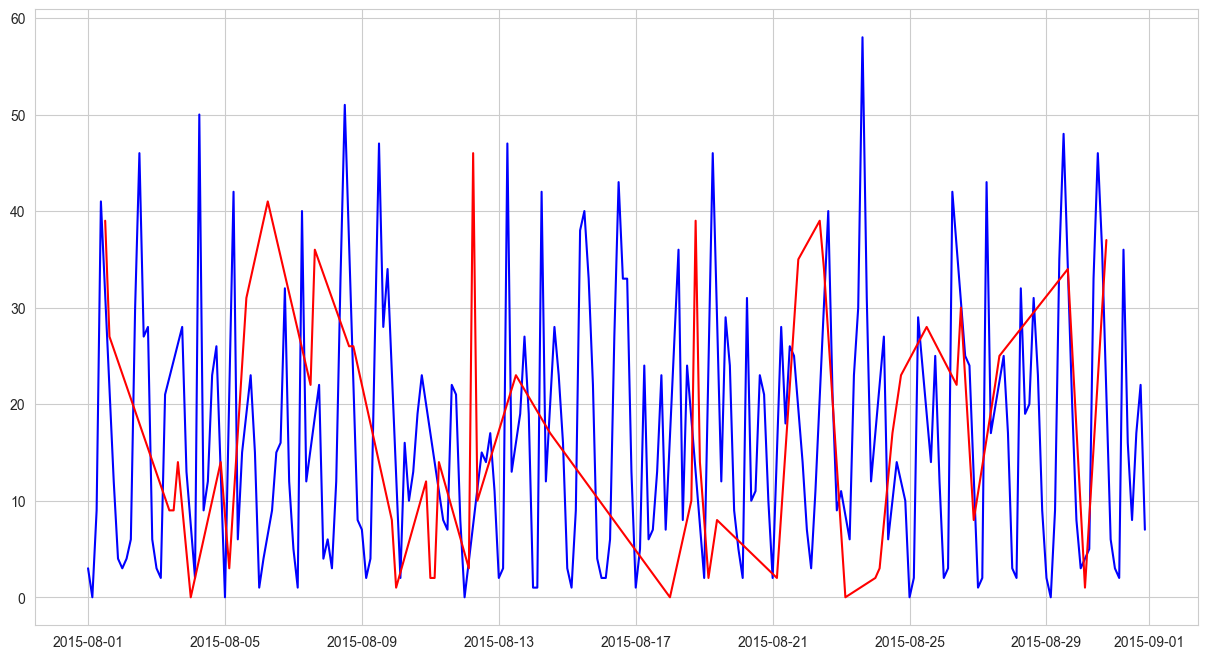

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")

In [11]:
citibike.shape

(248,)

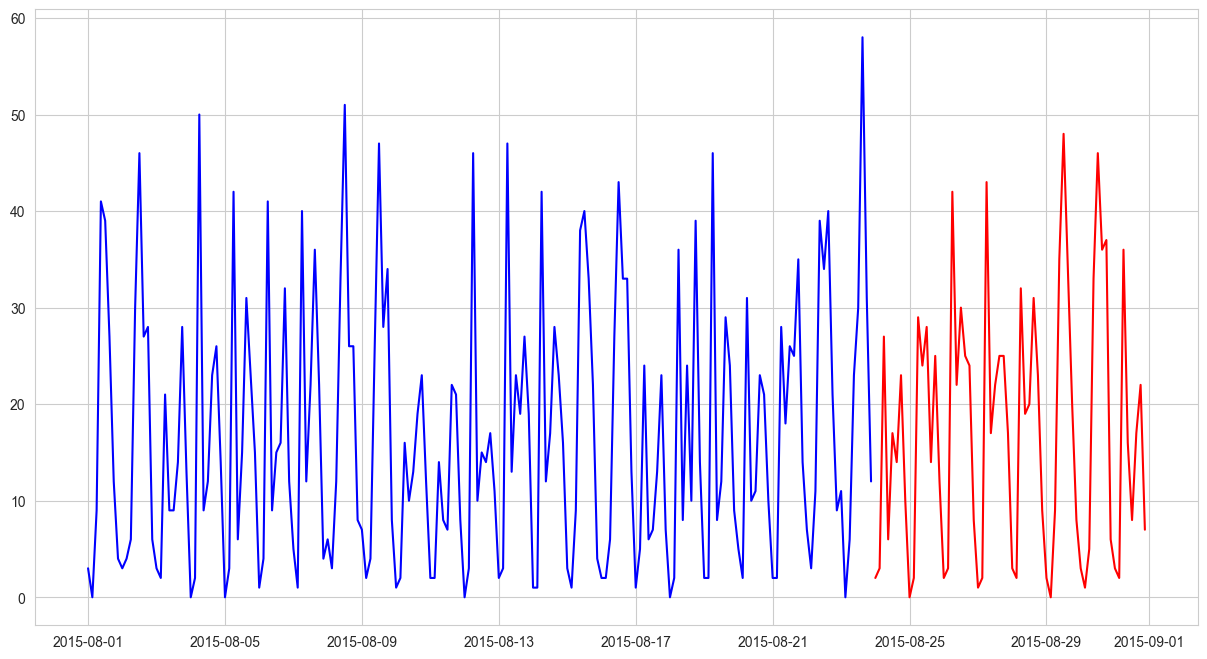

In [13]:
plt.figure(figsize=(15, 8))
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

plt.plot(train_df, "b", label="train")
plt.plot(test_df, "r", label="test")

* POSIX time, which is the number of seconds since January 1970 00:00:00

In [14]:
X = (
    citibike.index.astype("int64").values.reshape(-1, 1) // 10**9
)
y = citibike.values

In [19]:
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10**9
y_train = train_df.values
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10**9
y_test = test_df.values

In [20]:
X_train[:10]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400]])

* Our prediction task is a regression task

## Random Forest

* Let's try random forest with just this feature
* We will write a function that:
    * Splits the data
    * Trains the given regressor model on the training data
    * Shows train and test scores
    * Plots the predictions

In [32]:
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq="D")
def eval_on_features(features, target, regressor, n_train = 184, ylabel = 'Rentals'):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    regressor.fit(X_train, y_train)

    print("Train-set $R^2$", regressor.score(X_train, y_train))
    print("test-set $R^2$", regressor.score(X_test, y_test))

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")

    plt.plot(
        range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test"
    )
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)


Train-set $R^2$ 0.8532168110304772
test-set $R^2$ -0.035486463625959086


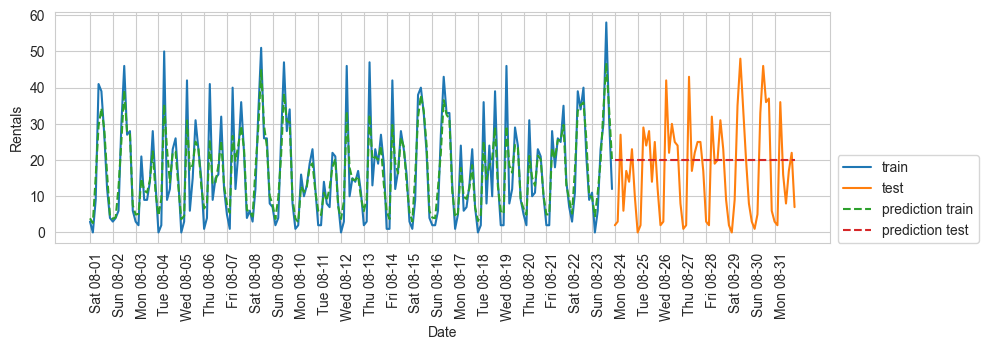

In [33]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
eval_on_features(X, y, regressor)

* Only one feature: POSIX time feature
* And the value of the POSIX time feature is outside the range of the feature values in the training set
* Tree-based models cannot extrapolate to feature ranges outside the training data
* The model predicted the target value of the closedt point in the training set

## Feature engineering

In [34]:
citibike.index

DatetimeIndex(['2015-08-01 00:00:00', '2015-08-01 03:00:00',
               '2015-08-01 06:00:00', '2015-08-01 09:00:00',
               '2015-08-01 12:00:00', '2015-08-01 15:00:00',
               '2015-08-01 18:00:00', '2015-08-01 21:00:00',
               '2015-08-02 00:00:00', '2015-08-02 03:00:00',
               ...
               '2015-08-30 18:00:00', '2015-08-30 21:00:00',
               '2015-08-31 00:00:00', '2015-08-31 03:00:00',
               '2015-08-31 06:00:00', '2015-08-31 09:00:00',
               '2015-08-31 12:00:00', '2015-08-31 15:00:00',
               '2015-08-31 18:00:00', '2015-08-31 21:00:00'],
              dtype='datetime64[ns]', name='starttime', length=248, freq='3h')

In [39]:
citibike.index.hour

Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
       ...
       18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
      dtype='int32', name='starttime', length=248)

* Let's add some features: hour and weekday

In [40]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour[:10]

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12],
       [15],
       [18],
       [21],
       [ 0],
       [ 3]], dtype=int32)

Train-set $R^2$ 0.4980504791107411
test-set $R^2$ 0.5995775993305429


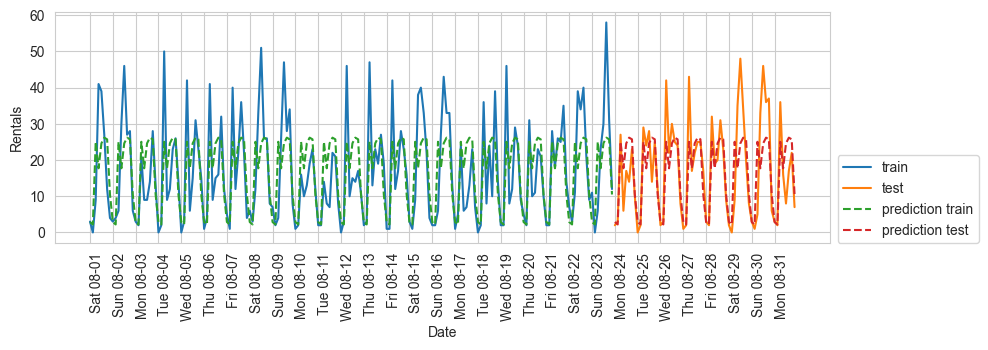

In [41]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor)

Train-set $R^2$ 0.8898923271329752
test-set $R^2$ 0.8419488587966024


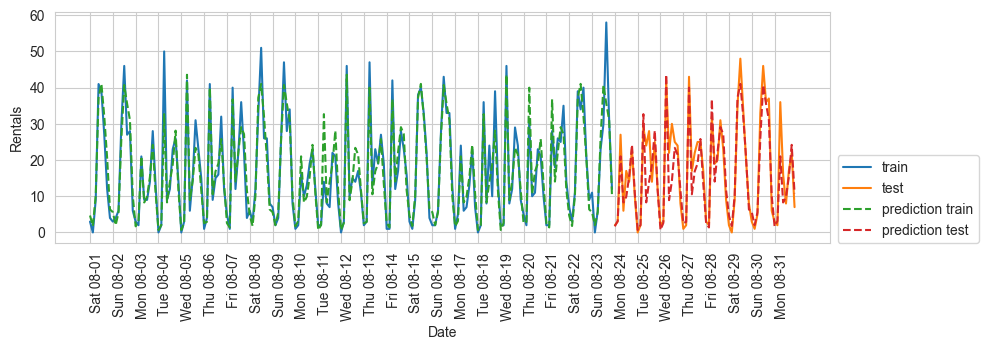

In [43]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

X_hour_week = np.hstack(
    [
        citibike.index.dayofweek.values.reshape(-1, 1),
        citibike.index.hour.values.reshape(-1, 1)
    ]
)

eval_on_features(X_hour_week, y, regressor)

Train-set $R^2$ 0.16319618892973364
test-set $R^2$ 0.1320745946979881


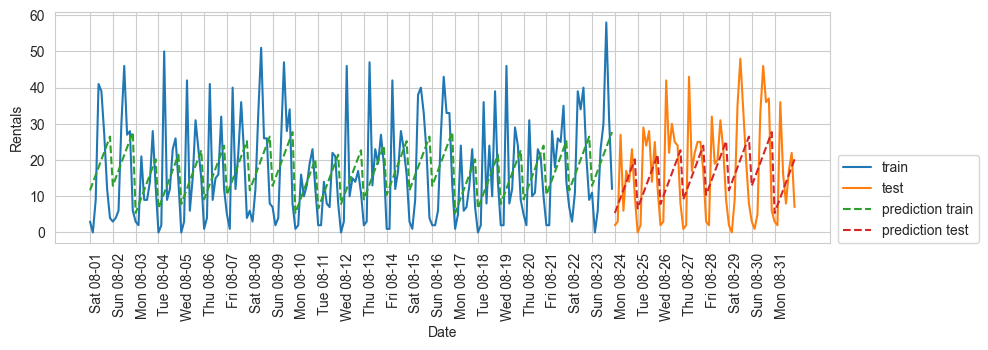

In [44]:
from sklearn.linear_model import Ridge

lr = Ridge()

eval_on_features(X_hour_week, y, lr)

In [46]:
enc = OneHotEncoder()

X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [49]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

features = day + hour

In [50]:
pd.DataFrame(X_hour_week_onehot, columns=features)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train-set $R^2$ 0.5346502225365404
test-set $R^2$ 0.6191139168658687


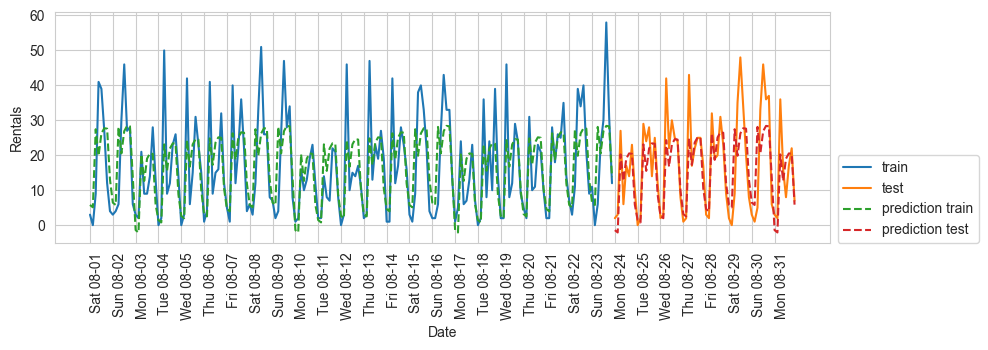

In [52]:
eval_on_features(X_hour_week_onehot, y, lr)


* What if we add interaction features (e.g., something like Day == 5 and hour==9)
* We can do if using `sklearn` `PolynomialFeatures` transformer

Train-set $R^2$ 0.8732875066328203
test-set $R^2$ 0.8451706357968556


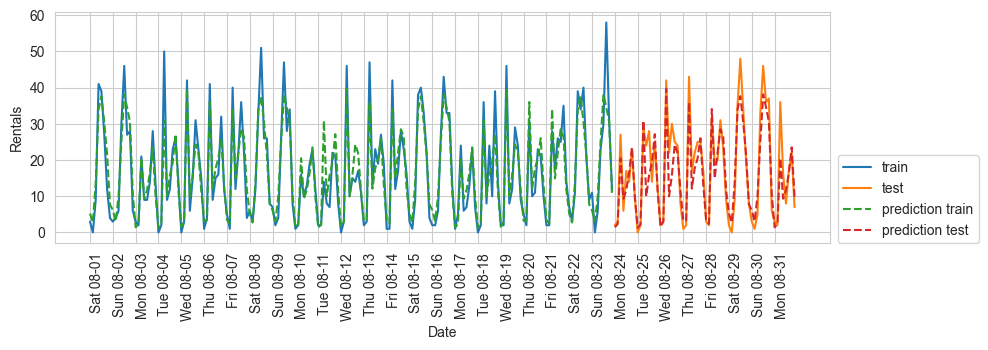

In [54]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only = True, include_bias = False
)

X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [55]:
features

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

In [56]:
features_poly = poly_transformer.get_feature_names_out(features)

features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_!= 0]

In [57]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns = ["Coefficient"]).sort_values("Coefficient", ascending=False)

,Coefficient
Sat 09:00,15.196739
Wed 06:00,15.005809
Sat 12:00,13.437684
Sun 12:00,13.362009
Thu 06:00,10.907595
...,...
Sat 21:00,-6.085150
00:00,-11.693898
03:00,-12.111220
Sat 06:00,-13.757591


* If it's Saturday 09:00 or Wed 06:00, the model is likely to predict bigger number for rentals
* If it's Midnight or 03:00 or Sat/Sunday 06:00, the model is likely to predict smaller number for rentals

## Lag-based features

In [58]:
rentals_df = pd.DataFrame(citibike)
rentals_df = rentals_df.rename(columns={"one":"n_rentals"})
rentals_df

,n_rentals
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39
...,...
2015-08-31 09:00:00,16
2015-08-31 12:00:00,8
2015-08-31 15:00:00,17


In [59]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [60]:
rentals_lag5 = create_lag_df(rentals_df, 5, ['n_rentals'] )

In [62]:
rentals_lag5

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
...,...,...,...,...,...,...
2015-08-31 09:00:00,16,36.0,2.0,3.0,6.0,37.0
2015-08-31 12:00:00,8,16.0,36.0,2.0,3.0,6.0
2015-08-31 15:00:00,17,8.0,16.0,36.0,2.0,3.0


In [63]:
X_lag_features = rentals_lag5.drop(columns = ['n_rentals']).to_numpy()

Train-set $R^2$ 0.25509193740419245
test-set $R^2$ 0.3681945875681327


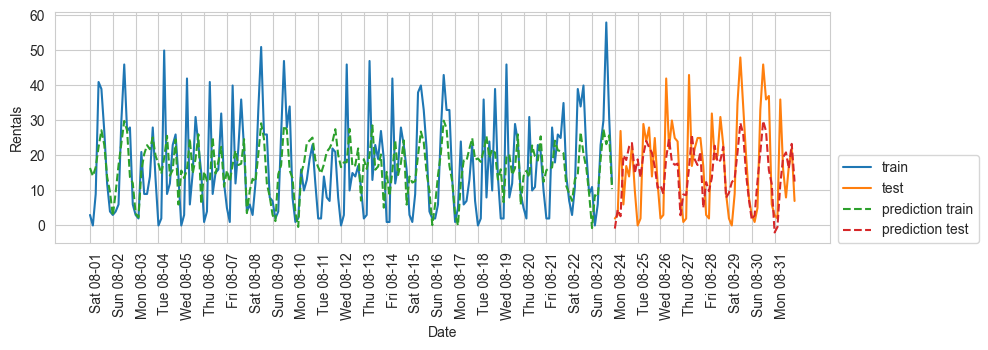

In [64]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
lr = Ridge()
eval_on_features(X_lag_features_imp, y, lr)


In [65]:
features_lag = rentals_lag5.drop(columns=['n_rentals']).columns.tolist()
features_nonzero = np.array(features_lag)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [66]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
n_rentals-1,0.165145
n_rentals-4,-0.049007
n_rentals-2,-0.215227
n_rentals-3,-0.258891
n_rentals-5,-0.373974


Train-set $R^2$ 0.9439383188043858
test-set $R^2$ 0.6830815163473405


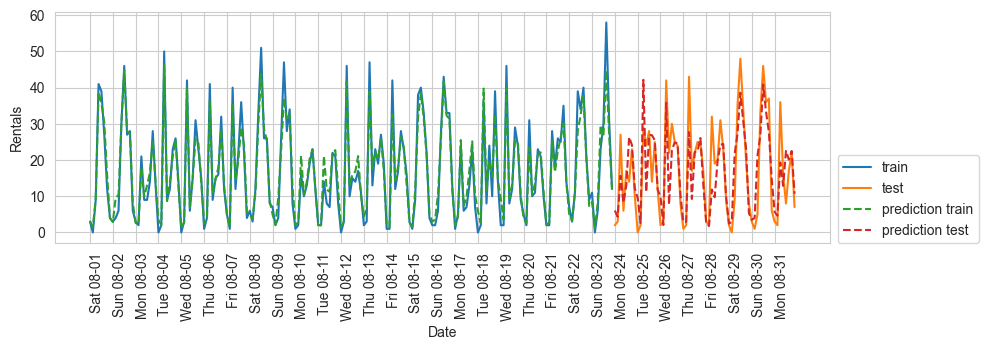

In [67]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
rf = RandomForestRegressor()
eval_on_features(X_lag_features_imp, y, rf)

## Cross-validation

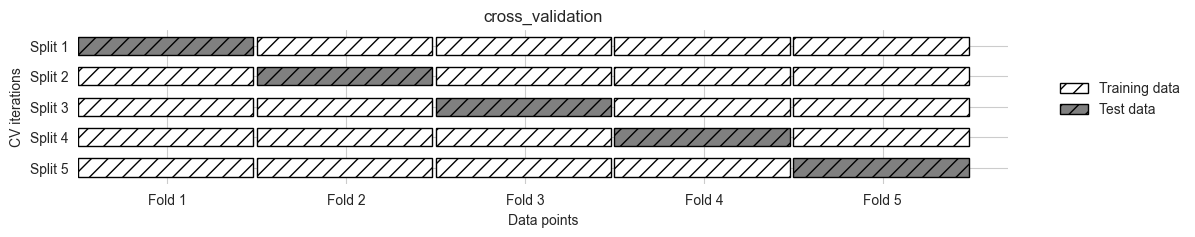

In [68]:
mglearn.plots.plot_cross_validation()

In [69]:
from sklearn.model_selection import TimeSeriesSplit

In [70]:
# Code from sklearn documentation
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_toy):
    print("%s %s" % (train, test))


[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


In [71]:
lr = Ridge()

In [72]:
scores = cross_validate(
    lr, X_hour_week_onehot_poly, y, cv=TimeSeriesSplit(), return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.050135,0.001451,0.642676,0.873182
1,0.209772,0.009660,0.828405,0.874305
2,0.309844,0.045546,0.773851,0.901262
3,0.327176,0.091879,0.696712,0.889429
4,0.426678,0.001303,0.892733,0.863889


# Next: ARIMA/SARIMA